<a href="https://colab.research.google.com/github/kayrunnings/Coursera_capstone/blob/master/Data_Preparation_and_Visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#@title
import pandas as pd
from google.colab import files
from google.colab import drive
import requests
import numpy as np
!pip install folium
import folium
import matplotlib.colors as colors
import matplotlib.cm as cm
import matplotlib.pyplot as plt
!pip install seaborn
import seaborn as sns

In [4]:
#@title
# import all flight data parts and put them into a dataframe
List=[]
i=0
while i<51:
  url="/content/drive/My Drive/Colab Notebooks/DHC South America Project/Flight Details (split)/Part {}.xlsx".format(i+1)
  List.append(url)
  i=i+1

a=pd.DataFrame()
i=0
while i<51:
  aa=pd.read_excel(List[i], index_col=0)
  a=a.append(aa)
  i=i+1

b=a.copy()
b.shape

(1706076, 17)

In [0]:
# creat OD Pairs column in the dataframe
ODList=[]
for x,y in zip(b["Origin Code"], b['Destination Code']):
  if x>y:
    z=x+'-'+y
  else:
    z=y+'-'+x
  ODList.append(z)
b["OD Pair"]=ODList

In [0]:
# create a pivot table to extract airline vs route count
airlinecount=b.pivot_table(index=['Op Airline Code', 'Op Airline Name'], columns=['OD Pair'], values='Travel Date', aggfunc=np.count_nonzero,fill_value=0)

# create airline MS for each route
airlinems=airlinecount/airlinecount[airlinecount.columns].sum()*100 
airlinems.reset_index(inplace=True)

In [0]:
# create airline count Origin airport and Destination airport
origincount=b.pivot_table(index=['Origin Code'], columns=['Op Airline Code'], values='Travel Date', aggfunc=np.count_nonzero,fill_value=0)
destinationcount=b.pivot_table(index=['Destination Code'], columns=['Op Airline Code'], values='Travel Date', aggfunc=np.count_nonzero,fill_value=0)

origincount.reset_index(inplace=True)
destinationcount.reset_index(inplace=True)

#merge and aggregate to get master count at each airport outbound and inbound
origincount.rename(columns={'Origin Code':'Airport Code'}, inplace=True)
destinationcount.rename(columns={'Destination Code':'Airport Code'}, inplace=True)
airportcount=origincount.iloc[0:,1:]+destinationcount.iloc[0:,1:]
airportcount.insert(0,"Airport Code",origincount["Airport Code"])

#create marketshare of each airline at each airport (NEED TO TRANSPOSE)

actemp=airportcount.transpose()
actemp.columns=actemp.iloc[0]
actemp=actemp.iloc[1:,]
airportms=actemp/actemp[actemp.columns].sum()*100 
airportms.reset_index(inplace=True)

In [0]:
# convert to floats
i=1
while i< len(airportms.columns):
  airportms[airportms.columns[i]]=airportms[airportms.columns[i]].astype(float)
  i=i+1

j=1
while i< len(airlinems.columns):
  airlinems[airlinems.columns[i]]=airlinems[airlinems.columns[i]].astype(float)
  j=j+1

In [0]:

# create a seperate datatable that lists OD Pairs with total number of flights and its route lengths
c=b.groupby(['OD Pair', 'Average Miles', 'Origin Code', 'Destination Code']).count()[['Travel Date']]
c.reset_index(inplace=True)
c.rename(columns={'Travel Date':'Total Count', 'Average Miles': 'Sector Length'}, inplace=True)

#filter out all routes that fit inside Dash 8-400s capabilities set at 800 miles
c.drop(c[c['Sector Length']>800].index, axis=0, inplace=True)
c.reset_index(drop=True, inplace=True)

In [0]:
#import airport information
AirportList=pd.DataFrame()
d=pd.read_excel('/content/drive/My Drive/Colab Notebooks/DHC South America Project/Airport Details.xlsx', index_col=1)
d.drop('Column1', axis=1, inplace=True)
d.reset_index(drop=False, inplace=True)

In [0]:
# create a map of South America and mark all the airports
#del map

map=folium.Map(
    location=[d['Lat'].mean(), d['Lon'].mean()],
    zoom_start=3.5)

#add poly lines to the map where the color is in accordance to the number of routes

j=0
points=[]
while j<c.shape[0]:
  id1=d[d['Airport Codes']==c.iloc[j,2]].index.values[0]
  point1=[float(d.iloc[id1,4]), float(d.iloc[id1,5])]

  id2=d[d['Airport Codes']==c.iloc[j,3]].index.values[0]
  point2=[float(d.iloc[id2,4]), float(d.iloc[id2,5])]

  points.append(tuple(point1))
  points.append(tuple(point2))
  
  airports=[d.iloc[id1,3], d.iloc[id2,3]]
  cities=[d.iloc[id1,1], d.iloc[id2,1]]
  length=float(c.iloc[j,1])
  count=float(c.iloc[j,4]) 
  
  alms1=airlinems.nlargest(3,columns=c.iloc[j,0]).iloc[0,0]
  alms2=airlinems.nlargest(3,columns=c.iloc[j,0]).iloc[1,0]
  alms3=airlinems.nlargest(3,columns=c.iloc[j,0]).iloc[2,0]
  
  tooltip='FROM {}, {} \n TO {}, {} \n length={} miles \n 2019 flight count={} \n dominante airlines are {}, {}, {}'.format(airports[0], cities[0], airports[1], cities[1], length, count, alms1, alms2, alms3)
  w=c.iloc[j,4]/18605*10
  folium.PolyLine(points, color="red", popup=tooltip, tooltip=tooltip, weight=w, opacity=0.5).add_to(map)
  folium.PolyLine(points, color="black", popup=tooltip, tooltip=tooltip, weight=5, opacity=0.02).add_to(map) #add dummy thickened lines to for easy tooltips
  points=[]
  j=j+1

#add markers for all airports
i=0
while i<d.shape[0]:
  lat=d.iloc[i,4]
  lon=d.iloc[i,5]
  airport=d.iloc[i,3]
  city=d.iloc[i,1]
  country=d.iloc[i,2]
  airportcode=d.iloc[i,0]
  
  alms1=airportms.nlargest(3,columns=d.iloc[i,0]).iloc[0,0]
  alms2=airportms.nlargest(3,columns=d.iloc[i,0]).iloc[1,0]
  alms3=airportms.nlargest(3,columns=d.iloc[i,0]).iloc[2,0]
  
  
  
  tooltip='{}\n{}\n{}\n{}\n{}\n Dominant airlines are {}, {}, {}'.format(airportcode, airport, city, country, [lat, lon], alms1, alms2, alms3)
  
  folium.CircleMarker(
      location=[lat, lon],
      radius=2,
      popup=tooltip,
      color='green',
      fill=True,
      fill_opacity=0.1,
      tooltip=tooltip
      ).add_to(map)
  folium.CircleMarker([lat,lon], color="black", popup='{}\n{}\n{}\n{}\n{}'.format(airportcode, airport, city, country, [lat, lon]), tooltip=tooltip, weight=5, opacity=0.01).add_to(map)
  i=i+1





#add title and legend

title_html = '''
             <h3 align="center" style="font-size:20px"><b>Route information for South America based on 2019 information </b></h3>
             <h4 align="left" style="font-size:12px"><b>The thickness of the line indicate the count of flights on that particular route in 2019. [min=1, max=18605] </b></h4>
             <h4 align="left" style="font-size:12px"><b>Hover or click on the route/airport for more details. Zoom in or out greater granularity </b></h4>
             
             
             '''
map.get_root().html.add_child(folium.Element(title_html))

#map
  

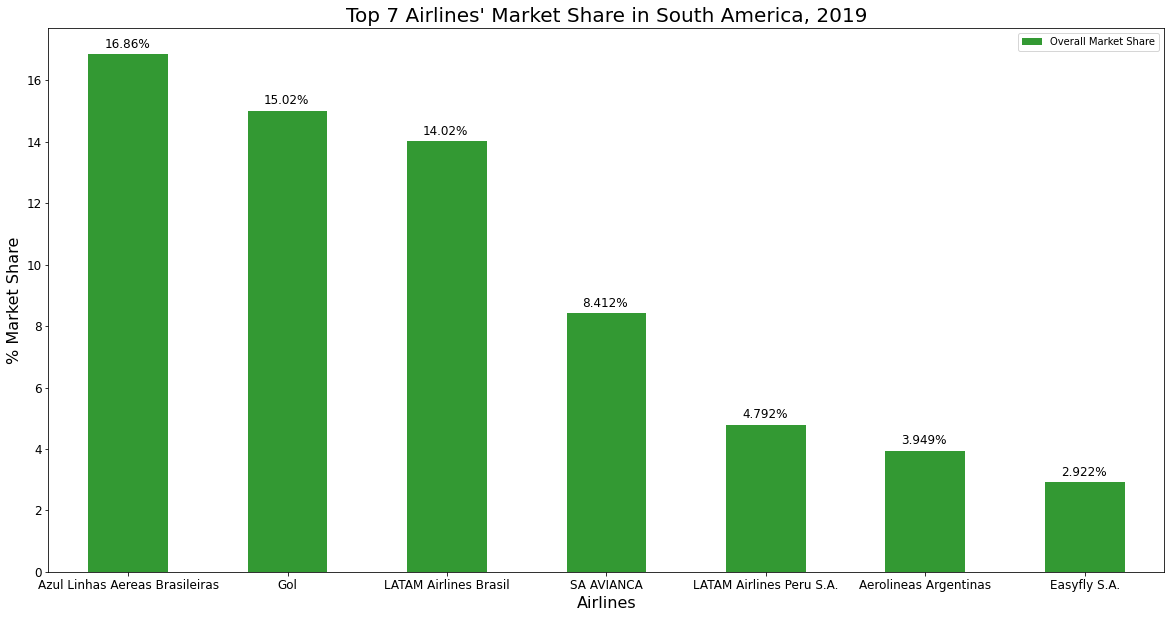

In [470]:
#For South American Marketshare distribution based on flight frequency

#extract airline vs total number of flights on routes less than 800

sa=b.copy()
b_temp=b[b['Average Miles']<800].index
#sa=sa.iloc[b_temp,]                      #uncomment/comment to use 800 mile condition
sacounts=sa.groupby('Op Airline Code')['Op Airline Name'].value_counts()
sams=pd.DataFrame(sacounts)
sams.rename(columns={'Op Airline Name':'Total Flight Count'}, inplace=True)
sams.reset_index(inplace=True)
sams.sort_values(by=['Total Flight Count'], ascending=False, inplace=True)
sams['Overall Market Share']=sams['Total Flight Count']/sams['Total Flight Count'].sum()*100

#take the top few and add 'others' column
n=7
x1=sams["Op Airline Name"][0:n]
y1=sams["Overall Market Share"][0:n]
y2=int(100-sams['Overall Market Share'][n:].sum())

#create a dummy dataframe for easy plotting
samsplotdata=pd.DataFrame([x1,y1]).transpose()
samsplotdata.set_index('Op Airline Name', drop=True, inplace=True)
#samsplotdata.loc['Other']=y2

#plot it!
saplot=samsplotdata.plot(kind='bar',
                  figsize=(20,10),
                  title='Top {} Airlines\' Market Share in South America, 2019'.format(n) , 
                  color='green', alpha=0.8,
                  fontsize=12,
                  table=False, 
                  
                  rot=0)

saplot.title.set_fontsize(20)

saplot.set_xlabel('Airlines', fontsize=16)
saplot.set_ylabel('% Market Share', fontsize=16, rotation=90)

for p in saplot.patches:
    saplot.annotate('{:.4}%'.format(float(str(p.get_height()))), (p.get_x()+0.1, p.get_height()+0.2), fontsize=12)

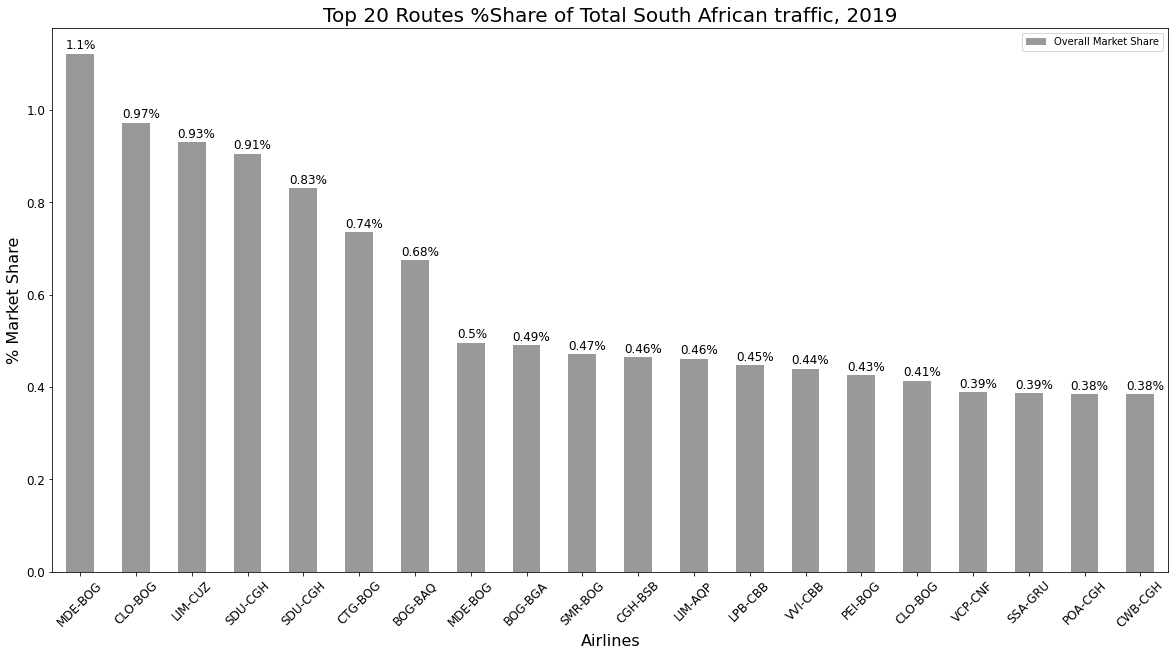

In [444]:
#For South American Route Share distribution based on flight frequency

#extract Route vs total number of flights on routes less than 800

sar=b.copy()
b_temp=b[b['Average Miles']<800].index
#sar=sar.iloc[b_temp,]                      #uncomment/comment to use 800 mile condition
sarcounts=sar.groupby('OD Pair')['Op Airline Name'].value_counts()
sars=pd.DataFrame(sarcounts)
sars.rename(columns={'Op Airline Name':'Total Flight Count'}, inplace=True)
sars.reset_index(inplace=True)
sars.sort_values(by=['Total Flight Count'], ascending=False, inplace=True)
sars['Overall Market Share']=sars['Total Flight Count']/sars['Total Flight Count'].sum()*100

#take the top few and add 'others' column
n=20   #set number here
x1=sars["OD Pair"][0:n]
y1=sars["Overall Market Share"][0:n]
y2=100-(sars['Overall Market Share'][n:].sum())

#create a dummy dataframe for easy plotting
sarsplotdata=pd.DataFrame([x1,y1]).transpose()
sarsplotdata.set_index('OD Pair', drop=True, inplace=True)
#sarsplotdata.loc['Other']=y2

#plot it!
sarplot=sarsplotdata.plot(kind='bar',
                  figsize=(20,10),
                  title='Top {} Routes %Share of Total South African traffic, 2019'.format(n), 
                  color='grey', alpha=0.8,
                  fontsize=12,
                  table=False, 
                  rot=45)

sarplot.title.set_fontsize(20)

sarplot.set_xlabel('Airlines', fontsize=16)
sarplot.set_ylabel('% Market Share', fontsize=16, rotation=90)

for p in sarplot.patches:
    sarplot.annotate('{:.2}%'.format(float(str(p.get_height()))), (p.get_x()+0.0, p.get_height()+0.01), fontsize=12)

In [464]:
map

In [0]:
map.save('South America Map v1.html')

In [0]:
files.save('South America Map v1.html')